#Consigna



Entrenar un modelo de segmentación basado en la arquitectura U-Net para resolver el problema de segmentación de neumotórax. 

Los datos se pueden descargar directamente a una máquina virtual (VM) de colab desde Kaggle. El instructivo para hacerlo (tener en cuanta que hay que descargar otra vez cuando termina la sesión). 

Se usarán los datos de:

https://www.kaggle.com/datasets/vbookshelf/pneumothorax-chest-xray-images-and-masks

Reportar la métrica de Dice para un conjunto de test a definir, el mismo dataset provee de un conjunto de imágenes de testeo. Puede usarse ese conjunto o separar un conjunto propio a partir de todos los datos.

Para este TP no hay una métrica objetivo a alcanzar, se intenta en lo posible que la métrica de Dice sea lo más cercana a 1. Reportar el modelo con mejor desempeño (hiperparámetros utilizados, si se usó aumentación de datos y qué tipo de aumentación, etc...) y mostrar algunos ejemplos de segmentación. No es necesario hacer un submit a Kaggle. 

Recomendaciones:

* Trabajar a partir de la notebook de segmentación vista en clase.
* Se puede entrenar y evaluar solamente con las imágenes que contengan patologías.








#Drive e importacion de librerias

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
!pip install pandas_summary
from pandas_summary import DataFrameSummary
import numpy as np
import datetime
!pip install isoweek
from isoweek import Week
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
!pip install sklearn_pandas
from sklearn_pandas import DataFrameMapper


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Dataset

Se genera un directorio de nombre siim-acr-pneumothorax. El contenido de este directorio son dos dataframes en formato .csv para las imágenes de train y test y dos directorios que contienen imágenes y sus máscaras de segmentación correspondientes. Las imágenes y las máscaras tienen un patrón de nombre formado por:

ID_SET_PAT_.png

Donde ID es un número de identificación, SET indica si la imagen pertenece al conjunto de "train" o "test" y PAT puede tomar los valores 0 o 1. 0 en el caso que esa imagen no contenga neumotórax y 1 en caso de que sí contenga patología. Este dataset se compone de 10675 imágenes de entrenamiento y 1372 de testeo.

Se utilizaron dos casos de dataset, el primero con 64 imagenes (elegidas aleatoriamente) de train y test y 64 masks train y test, todas con patalogia. Y para el segundo caso se hizo lo mismo pero con 2000 imagenes.

In [3]:
from PIL import Image
import numpy as np
import albumentations as A
from pathlib import Path
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [ ]:
#!cp -R "/content/drive/Shareddrives/Redes de Piluchina/TP 3/dataset_2/siim-acr-pneumothorax/"* /content/data

In [ ]:
#path_data ="/content/data/"

In [4]:
path_nuevoDataset = "/content/drive/Shareddrives/Redes de Piluchina/TP 3/dataset/siim-acr-pneumothorax/"

Dataset de 2000 imagenes

In [5]:
import random
def reducir_dataset_train_2(path,cant_elementos = 2000):
  filenames = [file.name for file in Path(path).glob('png_image/img/*train_1_.png')]
  new_filenames = random.sample(filenames, cant_elementos)
  for file in new_filenames:
    img = Image.open(path+"png_image/img/"+file)
    img.save("/content/data_reducida_images_2/"+file)
    mask = Image.open(path+"png_masks/img/"+file)
    mask.save("/content/data_reducida_masks_2/"+file)
  print("Len random element is :", len(new_filenames))

In [6]:
reducir_dataset_train_2(path_nuevoDataset)

Len random element is : 2000


Se abren algunas imagenes del dataset para ver como son.

In [7]:
img1 = Image.open(path_nuevoDataset+"png_image/img/10_train_1_.png")
mask1 = Image.open(path_nuevoDataset+"png_masks/img/10_train_1_.png")

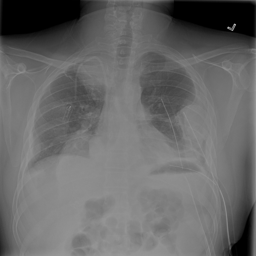

In [8]:
img1.resize((256,256))

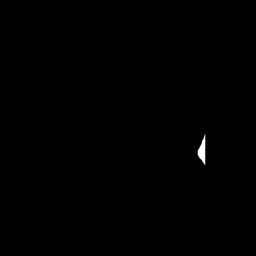

In [9]:
mask1.resize((256,256))

## Data-Augmentation

Dado que en general las redes Neuronales tienen grandes cantidades de parametros, necesitamos tener una cantidad proporcional de data a la cantidad de parametros para tener una buena performance. Por eso, se usa lo que se conoce como Data Augmentation que consiste en hacer alteraciones menores sobre el dataset para obtener más cantidad imagenes.

Estás alteraciones pueden ser: Flips, translations, rotations, entre otras, ya que nuestra red neuronal igualmente las va a distinguir como imagenes diferentes.

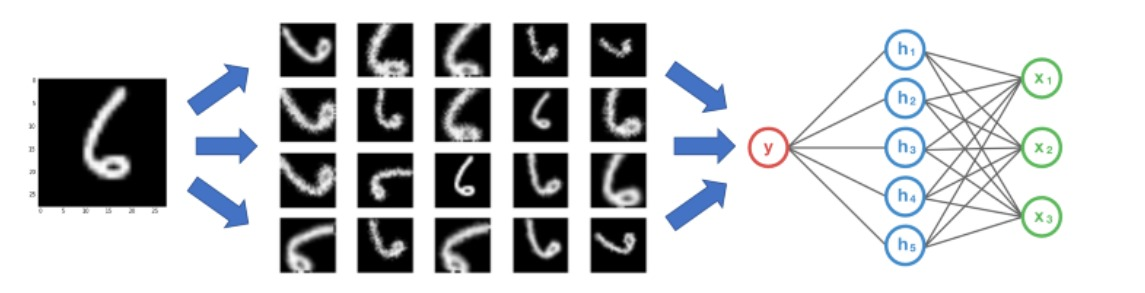

In [10]:
#VECTOR DE TRANSFORMACION DE DATA-AUGMENTATION

transform = A.Compose([
    A.RandomRotate90(),
    A.Transpose(),
    
])
#transform = False

#Generar data

Explicar que es un generetor, esto es para no tener todas las imagenes almacenadas,esto pasa cuando tenes muchos datos.

Hoy en día en el campo del Machine Learning cada vez se vuelve un problema más frecuente el hecho de tener que usar grandes datasets. El inconveniente es que al estar trabajando con imagenes el procesamiento por parte del modelo va a ocupar mucha memoria RAM, al usar un generador se evita tener el dataset entero ocupando espacio de forma necesaria.
Lo que se hace es generar un conjunto de datos en múltiples núcleos en tiempo real y alimentarlo de inmediato al modelo de red.

In [11]:
import tensorflow as tf
 
class DataGenerator_2(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, path, img_prefix, mask_prefix, transform=False, batch_size=4, dim=(64,64), train=True,n_channels=1, shuffle=True):
        'Initialization'
        self.path = path
        self.transform = transform
        self.n_channels = n_channels
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        if train:
            self.filenames = [file.name for file in Path(path).glob("data_reducida_images_2/*.png")]
        else:
            self.filenames = [file.name for file in Path(path).glob("png_image/img/*test_1_.png")]
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(filenames)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.filenames)

    def __data_generation(self, filenames):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, filename in enumerate(filenames):
            img = Image.open(self.path + self.img_prefix + filename).resize(self.dim)
            mask = Image.open(self.path + self.mask_prefix + filename).resize(self.dim)
            if self.transform:
                trf = self.transform(image = np.array(img), mask = np.array(mask))
                X[i,...] = trf['image'].reshape(*self.dim, self.n_channels)/255.
                y[i,...] = trf['mask'].reshape(*self.dim, self.n_channels)/255.
            else:
                X[i,...] = np.array(img).reshape(*self.dim, self.n_channels)/255.
                y[i,...] = np.array(mask).reshape(*self.dim, self.n_channels)/255.
        return X,y

Esta clase Generador es la que se pasara al modelo a fitear. A medida que se arman los batchs de entrenamiento, a cada imagen se le aplica:

- Una reducción de resolución.Por un tema de rápidez de procesamiento y poder agrandar el batch_size con el que se trabaja, se buscó hacer una reducción de resolución con la mínima cantidad de perdida de información posible, es por esto que se utilizo la dimension (128,128)


- Se le aplica la transformacion del Data Augmentation, excepto para el validation

- Cuando se usaron 64 imagenes se eligio un bachsize de 32, mientras que cuando se usaron 2000 imagenes se uso un bachsize de 64.


### Generacion data TRAIN

* Dataset 2000

In [12]:
datagen_2_False = DataGenerator_2(
    "/content/",
    "data_reducida_images_2/",
    "data_reducida_masks_2/",
    transform = False,
    shuffle= True,
    batch_size = 64,
    train = True  
)

In [13]:
len(datagen_2_False)

31

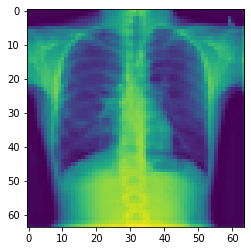

In [14]:
from matplotlib import pyplot as plt
plt.imshow(datagen_2_False[0][0][0].reshape(64,64))

In [15]:
datagen_2_True = DataGenerator_2(
    "/content/",
    "data_reducida_images_2/",
    "data_reducida_masks_2/",
    transform = transform,
    shuffle= True,
    batch_size = 64,
    train = True  
)

In [16]:
len(datagen_2_True)

31

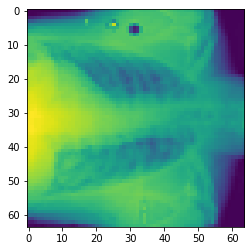

In [17]:
from matplotlib import pyplot as plt
plt.imshow(datagen_2_True[10][0][0].reshape(64,64))

### Generacion data VALIDATION

* Dataset 2000

In [18]:
datagen_val_2 = DataGenerator_2(
    "/content/",
    "data_reducida_images_2/",
    "data_reducida_masks_2/",
    transform = False,
    shuffle= True,
    batch_size = 64,
    train = True, 
)

#Modelo

## Descripcion del UNet

Una red neuronal convolucional  enfoca su tarea en la clasificacion de imagenes donde la entrada es una imagen y la salida es una etiqueta. En casos biomedicos se requiere no solo distinguir si hay una enfermedad si no tambien localizar el area de anormalidad y Unet puede resolver este problema ya que es capaz de localizar y distinguir bordes mediante la clasificacion de cada pixel, de modo que la entrada y la salida comparten el mismo tamaño.
La forma basica de la red se puede ver en la imganena continuacion:

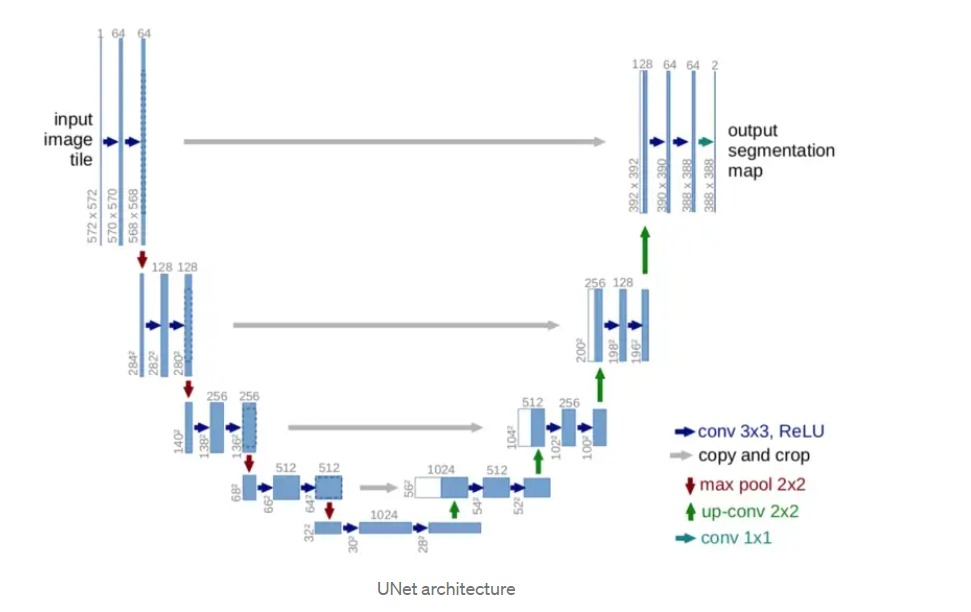

## Modelos planteados

In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K

In [20]:
# definición del coeficiente de Dice
def dice_coef(y_true, y_pred, smooth=1.0):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

# función de costo que combina binary crossentropy con Dice
def dice_coef_loss(y_true, y_pred):
    dice_term = 1 - dice_coef(y_true, y_pred)
    bce = tf.keras.losses.BinaryCrossentropy()
    loss = dice_term * 0.5 + bce(y_true, y_pred)*0.5
    return loss

In [21]:
# definición de bloques para armar la arquitectura de UNet

def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [22]:
# instanciación del modelo
model = UNet((64,64,1),start_ch=32,depth=5,batchnorm=False, residual = True,dropout=False)

In [23]:
# compilación
model.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

## Caso 8:
* 2000 imagenes, con Transform= True y epocs= 50

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint
epocs = 50
verbose = 1
monitor='loss'
filepath = f'/content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
#model.fit(datagen, epochs = epocs, validation_data=datagen_val, callbacks=[checkpointer])

In [25]:
history = model.fit(datagen_2_True, epochs = epocs, validation_data=datagen_val_2, callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.5958 - binary_crossentropy: 0.2090 - dice_coef: 0.0174
Epoch 1: val_loss improved from inf to 0.51875, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 129s 4s/step - loss: 0.5958 - binary_crossentropy: 0.2090 - dice_coef: 0.0174 - val_loss: 0.5188 - val_binary_crossentropy: 0.0761 - val_dice_coef: 0.0385
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.5121 - binary_crossentropy: 0.0750 - dice_coef: 0.0507
Epoch 2: val_loss improved from 0.51875 to 0.50484, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 115s 4s/step - loss: 0.5121 - binary_crossentropy: 0.0750 - dice_coef: 0.0507 - val_loss: 0.5048 - val_binary_crossentropy: 0.0729 - val_dice_coef: 0.0632
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.5051 - binary_crossentropy: 0.0776 - dice_coef: 0.0674
Epoch 3: val_loss improved from 0.50484 to 0.48910, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 113s 4s/step - loss: 0.5051 - binary_crossentropy: 0.0776 - dice_coef: 0.0674 - val_loss: 0.4891 - val_binary_crossentropy: 0.0859 - val_dice_coef: 0.1078
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.4920 - binary_crossentropy: 0.0823 - dice_coef: 0.0984
Epoch 4: val_loss improved from 0.48910 to 0.47550, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 111s 4s/step - loss: 0.4920 - binary_crossentropy: 0.0823 - dice_coef: 0.0984 - val_loss: 0.4755 - val_binary_crossentropy: 0.0874 - val_dice_coef: 0.1364
Epoch 5/50
31/31 [==============================] - ETA: 0s - loss: 0.4774 - binary_crossentropy: 0.0837 - dice_coef: 0.1289
Epoch 5: val_loss improved from 0.47550 to 0.44859, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 112s 4s/step - loss: 0.4774 - binary_crossentropy: 0.0837 - dice_coef: 0.1289 - val_loss: 0.4486 - val_binary_crossentropy: 0.0857 - val_dice_coef: 0.1886
Epoch 6/50
31/31 [==============================] - ETA: 0s - loss: 0.4629 - binary_crossentropy: 0.0844 - dice_coef: 0.1586
Epoch 6: val_loss improved from 0.44859 to 0.43835, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 111s 4s/step - loss: 0.4629 - binary_crossentropy: 0.0844 - dice_coef: 0.1586 - val_loss: 0.4383 - val_binary_crossentropy: 0.0801 - val_dice_coef: 0.2034
Epoch 7/50
31/31 [==============================] - ETA: 0s - loss: 0.4501 - binary_crossentropy: 0.0857 - dice_coef: 0.1856
Epoch 7: val_loss improved from 0.43835 to 0.41417, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 109s 4s/step - loss: 0.4501 - binary_crossentropy: 0.0857 - dice_coef: 0.1856 - val_loss: 0.4142 - val_binary_crossentropy: 0.0760 - val_dice_coef: 0.2476
Epoch 8/50
31/31 [==============================] - ETA: 0s - loss: 0.4387 - binary_crossentropy: 0.0828 - dice_coef: 0.2053
Epoch 8: val_loss did not improve from 0.41417
31/31 [==============================] - 105s 3s/step - loss: 0.4387 - binary_crossentropy: 0.0828 - dice_coef: 0.2053 - val_loss: 0.4144 - val_binary_crossentropy: 0.0864 - val_dice_coef: 0.2576
Epoch 9/50
31/31 [==============================] - ETA: 0s - loss: 0.4287 - binary_crossentropy: 0.0850 - dice_coef: 0.2277
Epoch 9: val_loss improved from 0.41417 to 0.41150, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 109s 4s/step - loss: 0.4287 - binary_crossentropy: 0.0850 - dice_coef: 0.2277 - val_loss: 0.4115 - val_binary_crossentropy: 0.0843 - val_dice_coef: 0.2613
Epoch 10/50
31/31 [==============================] - ETA: 0s - loss: 0.4255 - binary_crossentropy: 0.0824 - dice_coef: 0.2315
Epoch 10: val_loss improved from 0.41150 to 0.40905, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 111s 4s/step - loss: 0.4255 - binary_crossentropy: 0.0824 - dice_coef: 0.2315 - val_loss: 0.4090 - val_binary_crossentropy: 0.0907 - val_dice_coef: 0.2726
Epoch 11/50
31/31 [==============================] - ETA: 0s - loss: 0.4206 - binary_crossentropy: 0.0815 - dice_coef: 0.2402
Epoch 11: val_loss improved from 0.40905 to 0.39908, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 111s 4s/step - loss: 0.4206 - binary_crossentropy: 0.0815 - dice_coef: 0.2402 - val_loss: 0.3991 - val_binary_crossentropy: 0.0776 - val_dice_coef: 0.2794
Epoch 12/50
31/31 [==============================] - ETA: 0s - loss: 0.4092 - binary_crossentropy: 0.0802 - dice_coef: 0.2618
Epoch 12: val_loss improved from 0.39908 to 0.38698, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 110s 4s/step - loss: 0.4092 - binary_crossentropy: 0.0802 - dice_coef: 0.2618 - val_loss: 0.3870 - val_binary_crossentropy: 0.0700 - val_dice_coef: 0.2960
Epoch 13/50
31/31 [==============================] - ETA: 0s - loss: 0.4075 - binary_crossentropy: 0.0808 - dice_coef: 0.2658
Epoch 13: val_loss improved from 0.38698 to 0.37711, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 111s 4s/step - loss: 0.4075 - binary_crossentropy: 0.0808 - dice_coef: 0.2658 - val_loss: 0.3771 - val_binary_crossentropy: 0.0755 - val_dice_coef: 0.3213
Epoch 14/50
31/31 [==============================] - ETA: 0s - loss: 0.3989 - binary_crossentropy: 0.0798 - dice_coef: 0.2821
Epoch 14: val_loss improved from 0.37711 to 0.36924, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 110s 4s/step - loss: 0.3989 - binary_crossentropy: 0.0798 - dice_coef: 0.2821 - val_loss: 0.3692 - val_binary_crossentropy: 0.0717 - val_dice_coef: 0.3333
Epoch 15/50
31/31 [==============================] - ETA: 0s - loss: 0.3953 - binary_crossentropy: 0.0787 - dice_coef: 0.2881
Epoch 15: val_loss did not improve from 0.36924
31/31 [==============================] - 103s 3s/step - loss: 0.3953 - binary_crossentropy: 0.0787 - dice_coef: 0.2881 - val_loss: 0.3911 - val_binary_crossentropy: 0.0863 - val_dice_coef: 0.3042
Epoch 16/50
31/31 [==============================] - ETA: 0s - loss: 0.3886 - binary_crossentropy: 0.0775 - dice_coef: 0.3002
Epoch 16: val_loss did not improve from 0.36924
31/31 [==============================] - 102s 3s/step - loss: 0.3886 - binary_crossentropy: 0.0775 - dice_coef: 0.3002 - val_loss: 0.3725 - val_binary_crossentropy: 0.0686 - val_dice_coef: 0.3236
Epoch 17/50
31/31 [==============================] - ETA: 0s - l

31/31 [==============================] - 108s 4s/step - loss: 0.3859 - binary_crossentropy: 0.0770 - dice_coef: 0.3053 - val_loss: 0.3623 - val_binary_crossentropy: 0.0801 - val_dice_coef: 0.3555
Epoch 18/50
31/31 [==============================] - ETA: 0s - loss: 0.3909 - binary_crossentropy: 0.0792 - dice_coef: 0.2973
Epoch 18: val_loss improved from 0.36230 to 0.36224, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 110s 4s/step - loss: 0.3909 - binary_crossentropy: 0.0792 - dice_coef: 0.2973 - val_loss: 0.3622 - val_binary_crossentropy: 0.0721 - val_dice_coef: 0.3476
Epoch 19/50
31/31 [==============================] - ETA: 0s - loss: 0.3805 - binary_crossentropy: 0.0778 - dice_coef: 0.3168
Epoch 19: val_loss improved from 0.36224 to 0.35302, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 110s 4s/step - loss: 0.3805 - binary_crossentropy: 0.0778 - dice_coef: 0.3168 - val_loss: 0.3530 - val_binary_crossentropy: 0.0748 - val_dice_coef: 0.3687
Epoch 20/50
31/31 [==============================] - ETA: 0s - loss: 0.3794 - binary_crossentropy: 0.0761 - dice_coef: 0.3173
Epoch 20: val_loss did not improve from 0.35302
31/31 [==============================] - 103s 3s/step - loss: 0.3794 - binary_crossentropy: 0.0761 - dice_coef: 0.3173 - val_loss: 0.3591 - val_binary_crossentropy: 0.0815 - val_dice_coef: 0.3632
Epoch 21/50
31/31 [==============================] - ETA: 0s - loss: 0.3772 - binary_crossentropy: 0.0760 - dice_coef: 0.3216
Epoch 21: val_loss did not improve from 0.35302
31/31 [==============================] - 102s 3s/step - loss: 0.3772 - binary_crossentropy: 0.0760 - dice_coef: 0.3216 - val_loss: 0.3621 - val_binary_crossentropy: 0.0827 - val_dice_coef: 0.3586
Epoch 22/50
31/31 [==============================] - ETA: 0s - l

31/31 [==============================] - 108s 4s/step - loss: 0.3663 - binary_crossentropy: 0.0754 - dice_coef: 0.3428 - val_loss: 0.3368 - val_binary_crossentropy: 0.0676 - val_dice_coef: 0.3940
Epoch 27/50
31/31 [==============================] - ETA: 0s - loss: 0.3641 - binary_crossentropy: 0.0743 - dice_coef: 0.3461
Epoch 27: val_loss did not improve from 0.33680
31/31 [==============================] - 103s 3s/step - loss: 0.3641 - binary_crossentropy: 0.0743 - dice_coef: 0.3461 - val_loss: 0.3458 - val_binary_crossentropy: 0.0598 - val_dice_coef: 0.3683
Epoch 28/50
31/31 [==============================] - ETA: 0s - loss: 0.3629 - binary_crossentropy: 0.0736 - dice_coef: 0.3478
Epoch 28: val_loss did not improve from 0.33680
31/31 [==============================] - 102s 3s/step - loss: 0.3629 - binary_crossentropy: 0.0736 - dice_coef: 0.3478 - val_loss: 0.3398 - val_binary_crossentropy: 0.0721 - val_dice_coef: 0.3925
Epoch 29/50
31/31 [==============================] - ETA: 0s - l

31/31 [==============================] - 108s 4s/step - loss: 0.3514 - binary_crossentropy: 0.0711 - dice_coef: 0.3683 - val_loss: 0.3266 - val_binary_crossentropy: 0.0653 - val_dice_coef: 0.4121
Epoch 30/50
31/31 [==============================] - ETA: 0s - loss: 0.3566 - binary_crossentropy: 0.0742 - dice_coef: 0.3609
Epoch 30: val_loss improved from 0.32663 to 0.32562, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 109s 4s/step - loss: 0.3566 - binary_crossentropy: 0.0742 - dice_coef: 0.3609 - val_loss: 0.3256 - val_binary_crossentropy: 0.0619 - val_dice_coef: 0.4107
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.3518 - binary_crossentropy: 0.0714 - dice_coef: 0.3678
Epoch 31: val_loss improved from 0.32562 to 0.32529, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 110s 4s/step - loss: 0.3518 - binary_crossentropy: 0.0714 - dice_coef: 0.3678 - val_loss: 0.3253 - val_binary_crossentropy: 0.0674 - val_dice_coef: 0.4169
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.3484 - binary_crossentropy: 0.0713 - dice_coef: 0.3746
Epoch 32: val_loss did not improve from 0.32529
31/31 [==============================] - 102s 3s/step - loss: 0.3484 - binary_crossentropy: 0.0713 - dice_coef: 0.3746 - val_loss: 0.3255 - val_binary_crossentropy: 0.0646 - val_dice_coef: 0.4136
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.3509 - binary_crossentropy: 0.0724 - dice_coef: 0.3705
Epoch 33: val_loss did not improve from 0.32529
31/31 [==============================] - 102s 3s/step - loss: 0.3509 - binary_crossentropy: 0.0724 - dice_coef: 0.3705 - val_loss: 0.3281 - val_binary_crossentropy: 0.0655 - val_dice_coef: 0.4093
Epoch 34/50
31/31 [==============================] - ETA: 0s - l

31/31 [==============================] - 109s 4s/step - loss: 0.3453 - binary_crossentropy: 0.0712 - dice_coef: 0.3807 - val_loss: 0.3155 - val_binary_crossentropy: 0.0586 - val_dice_coef: 0.4276
Epoch 35/50
31/31 [==============================] - ETA: 0s - loss: 0.3370 - binary_crossentropy: 0.0703 - dice_coef: 0.3963
Epoch 35: val_loss improved from 0.31549 to 0.30440, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 110s 4s/step - loss: 0.3370 - binary_crossentropy: 0.0703 - dice_coef: 0.3963 - val_loss: 0.3044 - val_binary_crossentropy: 0.0626 - val_dice_coef: 0.4538
Epoch 36/50
31/31 [==============================] - ETA: 0s - loss: 0.3397 - binary_crossentropy: 0.0701 - dice_coef: 0.3906
Epoch 36: val_loss did not improve from 0.30440
31/31 [==============================] - 102s 3s/step - loss: 0.3397 - binary_crossentropy: 0.0701 - dice_coef: 0.3906 - val_loss: 0.3131 - val_binary_crossentropy: 0.0707 - val_dice_coef: 0.4445
Epoch 37/50
31/31 [==============================] - ETA: 0s - loss: 0.3414 - binary_crossentropy: 0.0712 - dice_coef: 0.3884
Epoch 37: val_loss did not improve from 0.30440
31/31 [==============================] - 102s 3s/step - loss: 0.3414 - binary_crossentropy: 0.0712 - dice_coef: 0.3884 - val_loss: 0.3070 - val_binary_crossentropy: 0.0650 - val_dice_coef: 0.4511
Epoch 38/50
31/31 [==============================] - ETA: 0s - l

31/31 [==============================] - 109s 4s/step - loss: 0.3339 - binary_crossentropy: 0.0699 - dice_coef: 0.4022 - val_loss: 0.3032 - val_binary_crossentropy: 0.0584 - val_dice_coef: 0.4519
Epoch 39/50
31/31 [==============================] - ETA: 0s - loss: 0.3394 - binary_crossentropy: 0.0707 - dice_coef: 0.3919
Epoch 39: val_loss did not improve from 0.30325
31/31 [==============================] - 103s 3s/step - loss: 0.3394 - binary_crossentropy: 0.0707 - dice_coef: 0.3919 - val_loss: 0.3167 - val_binary_crossentropy: 0.0761 - val_dice_coef: 0.4427
Epoch 40/50
31/31 [==============================] - ETA: 0s - loss: 0.3365 - binary_crossentropy: 0.0694 - dice_coef: 0.3965
Epoch 40: val_loss did not improve from 0.30325
31/31 [==============================] - 103s 3s/step - loss: 0.3365 - binary_crossentropy: 0.0694 - dice_coef: 0.3965 - val_loss: 0.3059 - val_binary_crossentropy: 0.0673 - val_dice_coef: 0.4555
Epoch 41/50
31/31 [==============================] - ETA: 0s - l

31/31 [==============================] - 108s 4s/step - loss: 0.3292 - binary_crossentropy: 0.0687 - dice_coef: 0.4103 - val_loss: 0.3009 - val_binary_crossentropy: 0.0666 - val_dice_coef: 0.4649
Epoch 42/50
31/31 [==============================] - ETA: 0s - loss: 0.3254 - binary_crossentropy: 0.0678 - dice_coef: 0.4169
Epoch 42: val_loss did not improve from 0.30090
31/31 [==============================] - 103s 3s/step - loss: 0.3254 - binary_crossentropy: 0.0678 - dice_coef: 0.4169 - val_loss: 0.3028 - val_binary_crossentropy: 0.0700 - val_dice_coef: 0.4644
Epoch 43/50
31/31 [==============================] - ETA: 0s - loss: 0.3235 - binary_crossentropy: 0.0680 - dice_coef: 0.4210
Epoch 43: val_loss improved from 0.30090 to 0.29803, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 109s 4s/step - loss: 0.3235 - binary_crossentropy: 0.0680 - dice_coef: 0.4210 - val_loss: 0.2980 - val_binary_crossentropy: 0.0612 - val_dice_coef: 0.4652
Epoch 44/50
31/31 [==============================] - ETA: 0s - loss: 0.3223 - binary_crossentropy: 0.0681 - dice_coef: 0.4235
Epoch 44: val_loss improved from 0.29803 to 0.29268, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 109s 4s/step - loss: 0.3223 - binary_crossentropy: 0.0681 - dice_coef: 0.4235 - val_loss: 0.2927 - val_binary_crossentropy: 0.0590 - val_dice_coef: 0.4736
Epoch 45/50
31/31 [==============================] - ETA: 0s - loss: 0.3284 - binary_crossentropy: 0.0675 - dice_coef: 0.4107
Epoch 45: val_loss improved from 0.29268 to 0.28651, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 110s 4s/step - loss: 0.3284 - binary_crossentropy: 0.0675 - dice_coef: 0.4107 - val_loss: 0.2865 - val_binary_crossentropy: 0.0617 - val_dice_coef: 0.4887
Epoch 46/50
31/31 [==============================] - ETA: 0s - loss: 0.3170 - binary_crossentropy: 0.0665 - dice_coef: 0.4326
Epoch 46: val_loss improved from 0.28651 to 0.28140, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 109s 4s/step - loss: 0.3170 - binary_crossentropy: 0.0665 - dice_coef: 0.4326 - val_loss: 0.2814 - val_binary_crossentropy: 0.0597 - val_dice_coef: 0.4969
Epoch 47/50
31/31 [==============================] - ETA: 0s - loss: 0.3159 - binary_crossentropy: 0.0663 - dice_coef: 0.4346
Epoch 47: val_loss improved from 0.28140 to 0.28027, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True


31/31 [==============================] - 110s 4s/step - loss: 0.3159 - binary_crossentropy: 0.0663 - dice_coef: 0.4346 - val_loss: 0.2803 - val_binary_crossentropy: 0.0555 - val_dice_coef: 0.4949
Epoch 48/50
31/31 [==============================] - ETA: 0s - loss: 0.3139 - binary_crossentropy: 0.0657 - dice_coef: 0.4379
Epoch 48: val_loss did not improve from 0.28027
31/31 [==============================] - 103s 3s/step - loss: 0.3139 - binary_crossentropy: 0.0657 - dice_coef: 0.4379 - val_loss: 0.2870 - val_binary_crossentropy: 0.0644 - val_dice_coef: 0.4903
Epoch 49/50
31/31 [==============================] - ETA: 0s - loss: 0.3108 - binary_crossentropy: 0.0648 - dice_coef: 0.4433
Epoch 49: val_loss did not improve from 0.28027
31/31 [==============================] - 102s 3s/step - loss: 0.3108 - binary_crossentropy: 0.0648 - dice_coef: 0.4433 - val_loss: 0.2813 - val_binary_crossentropy: 0.0539 - val_dice_coef: 0.4913
Epoch 50/50
31/31 [==============================] - ETA: 0s - l

Se guarda el history del modelo:

In [26]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(model.history.history) 

# or save to csv: 
hist_csv_file = '/content/drive/Shareddrives/Redes de Piluchina/TP 3/historys_de_modelos_lindos/history_Modelo_Trainde2000_epochs50_Transform=True.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

Se levantan los pesos del modelo:

In [27]:
filepath = f'/content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=True'
model.load_weights(filepath)

Se levanta el history:

In [28]:
history_path = '/content/drive/Shareddrives/Redes de Piluchina/TP 3/historys_de_modelos_lindos/history_Modelo_Trainde2000_epochs50_Transform=True.csv'
history = pd.read_csv(history_path)
history.head()

,Unnamed: 0,loss,binary_crossentropy,dice_coef,val_loss,val_binary_crossentropy,val_dice_coef
0,0,0.595794,0.208990,0.017403,0.518754,0.076056,0.038547
1,1,0.512126,0.074971,0.050719,0.504843,0.072925,0.063238
2,2,0.505089,0.077598,0.067420,0.489097,0.085948,0.107754
3,3,0.491961,0.082303,0.098381,0.475499,0.087404,0.136405
4,4,0.477402,0.083667,0.128862,0.448595,0.085747,0.188558


Ploteamos el history:


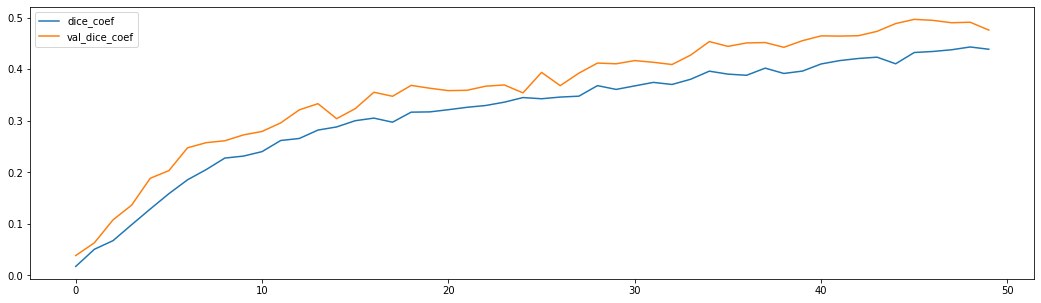

In [29]:
plt.figure(figsize=(18,5))
plt.plot(history['dice_coef'],label = "dice_coef")
plt.plot(history['val_dice_coef'], label="val_dice_coef")
plt.legend()
plt.show();

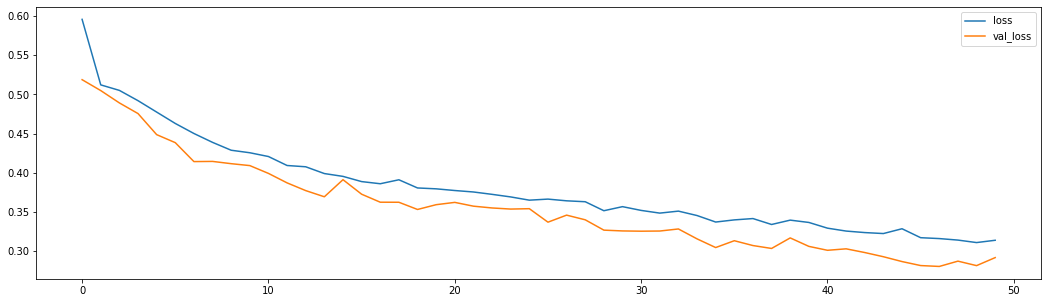

In [30]:
plt.figure(figsize=(18,5))
plt.plot(history['loss'],label = "loss")
plt.plot(history['val_loss'], label="val_loss")
plt.legend()
plt.show();



#Predicciones

##Generar data

In [31]:
path_test = "/content/drive/Shareddrives/Redes de Piluchina/TP 3/dataset/siim-acr-pneumothorax/"

* Dataset 2000

In [32]:
datagen_test_2 = DataGenerator_2(
    path_test,
    "png_image/img/",
    "png_masks/img/",
    transform = False,
    shuffle= False,
    batch_size = 64,
    train = False, 
)

In [33]:
datagen_test_2[0][0].shape

(64, 64, 64, 1)

##Caso 8

* 2000 imagenes, con Transform= True y epocs= 50

In [34]:
pred_test = model.predict(datagen_test_2)

4/4 [==============================] - 345s 114s/step


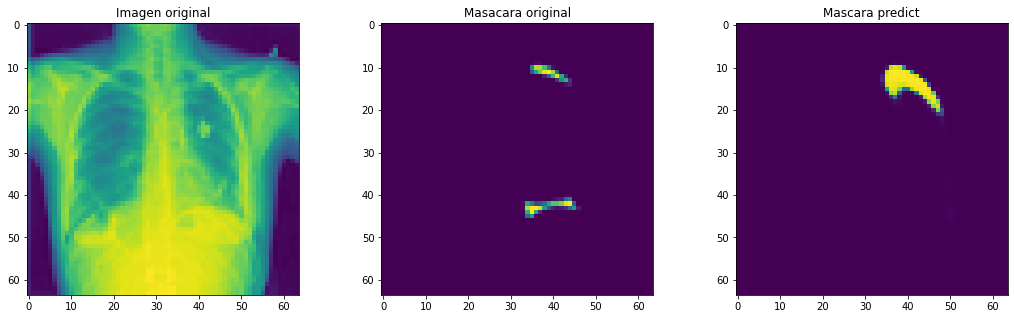

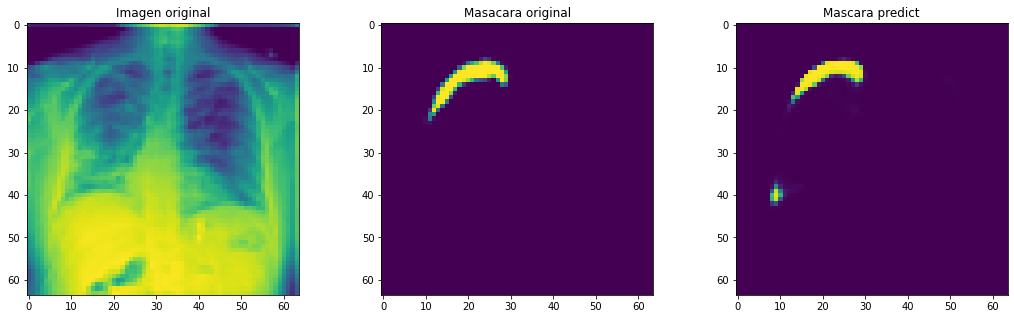

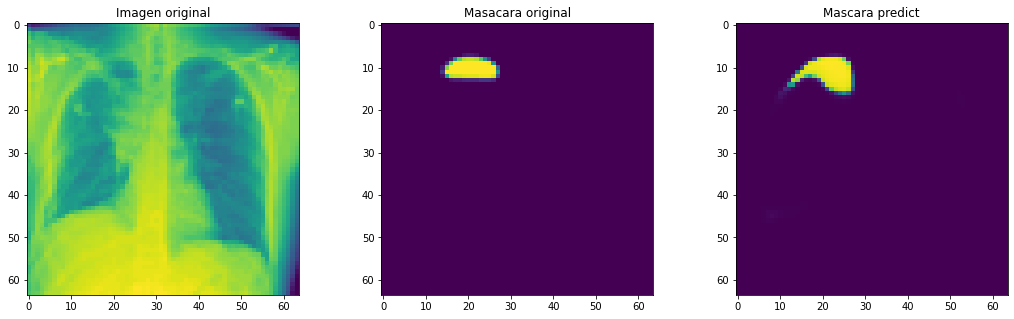

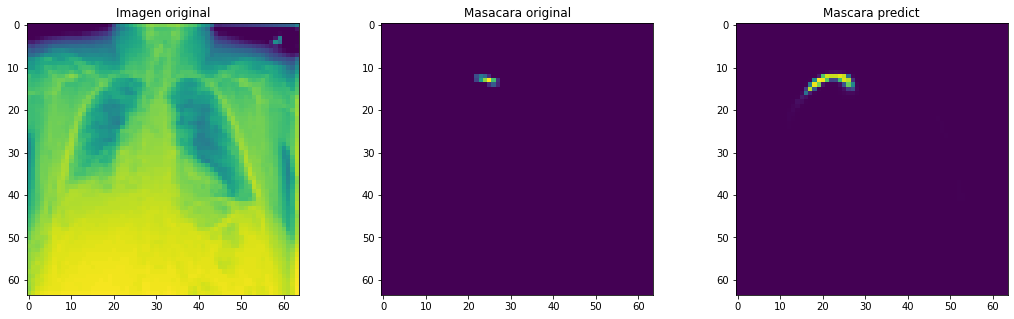

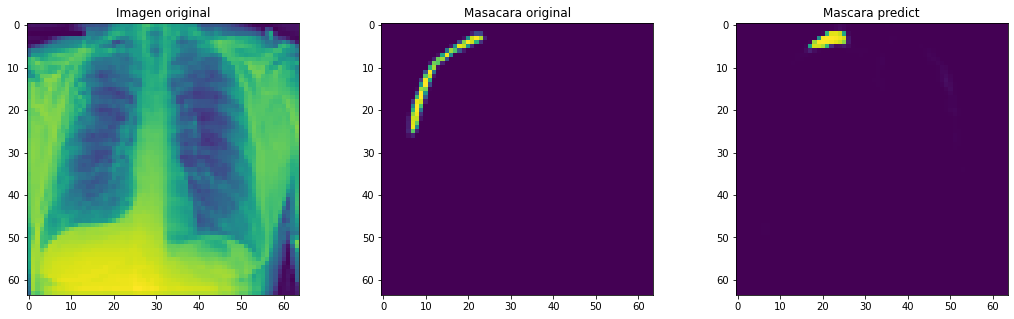

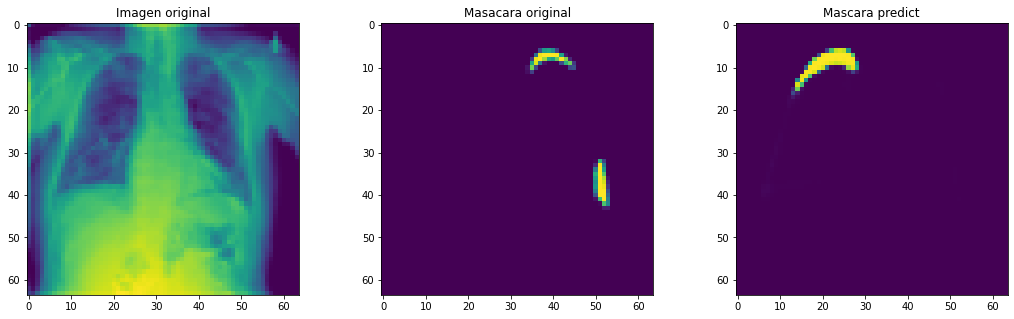

In [36]:
for idx in range(6):
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(18,5))
  ax1.imshow(datagen_test_2[0][0][idx].reshape(64,64))
  ax1.set_title("Imagen original")
  ax2.imshow(datagen_test_2[0][1][idx].reshape(64,64))
  ax2.set_title("Masacara original")
  ax3.imshow(pred_test[idx].reshape(64,64))
  ax3.set_title("Mascara predict")
  plt.show();